In [1]:
import pystan as ps
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import btom as bt

In [2]:
a = bt.BinomialGinibreStateSampler()

In [3]:
pz = (qt.identity(1) + qt.sigmaz()).data.toarray() / 2
px = (qt.identity(1) + qt.sigmax()).data.toarray() / 2
py = (qt.identity(1) + qt.sigmay()).data.toarray() / 2

In [4]:
a.sample({
    'D': 2,
    'm': 3,
    'M_real': list(np.real(np.array([px, py, pz]))),
    'M_imag': np.imag(np.array([px, py, pz])),
    'n': [10,10,10],
    'k': [5, 5, 3]
})

/home/ihincks/.miniconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


array([[[ 0.52842649+0.j,  0.06311616+0.j],
        [ 0.06311616+0.j,  0.47157351+0.j]],

       [[ 0.24493414+0.j,  0.00539475+0.j],
        [ 0.00539475+0.j,  0.75506586+0.j]],

       [[ 0.16832132+0.j, -0.11785519+0.j],
        [-0.11785519+0.j,  0.83167868+0.j]],

       ...,

       [[ 0.25219811+0.j, -0.0844935 +0.j],
        [-0.0844935 +0.j,  0.74780189+0.j]],

       [[ 0.34041795+0.j, -0.08001025+0.j],
        [-0.08001025+0.j,  0.65958205+0.j]],

       [[ 0.31320959+0.j,  0.07760808+0.j],
        [ 0.07760808+0.j,  0.68679041+0.j]]])

In [6]:
a = bt.utils.StanModelFactory.load_builtin_model('binomial-ginibre.stan')

In [8]:
a = {}

In [9]:
a.update({'a':4})

In [11]:
def test(x):
    x.update({'b':6})

In [13]:
test(a)

In [14]:
a

{'a': 4, 'b': 6}

In [7]:
a.model

In [9]:
a.storage_filename

'/home/ihincks/academics/research/projects/btom/btom/stan/binomial-ginibre.pkl'

In [5]:
os.path.basename('./btom/stan/test-pos.stan')

'test-pos.stan'

In [6]:
bt.PoissonGinibreSampler()

TypeError: Can't instantiate abstract class PoissonGinibreSampler with abstract methods sample

In [2]:
m = StanModelFactory('./btom/stan/test-pos3.stan').model

In [5]:
qt.Qobj

qutip.qobj.Qobj

In [9]:
pz.data.toarray()

AttributeError: 'memoryview' object has no attribute 'toarray'

In [11]:
data.__getitem__

<function dict.__getitem__>

In [10]:
data = {
    'D': 2,
    'K': 2,
    'm': 3,
    'M_real': list(np.real(np.array([px, py, pz]))),
    'M_imag': np.imag(np.array([px, py, pz])),
    'n': [10,10,10],
    'k': [5, 5, 3]
}

In [13]:
f

NameError: name 'f' is not defined

In [14]:
class TomographyPosterior(object):
    def __init__(self, n, k, meas_ops):
        self.model = StanModelFactory('./btom/stan/test-pos3.stan').model
        self.n = n
        self.k = k
        self.meas_ops = meas_ops
        self._fit = None
        
    @property
    def dim(self):
        return self.meas_ops[0].shape[0]
    
    @property
    def n_meas_ops(self):
        return len(self.meas_ops)
        
    def stan_data(self, ginibre_k):
        return {
            'D': self.dim,
            'K': ginibre_k,
            'm': self.n_meas_ops,
            'M_real': np.real(self.meas_ops),
            'M_imag': np.imag(self.meas_ops),
            'n': self.n,
            'k': self.k
        }
    
    def sample(self, ginibre_k, n_chains=3, n_samples=1000):
        data = self.stan_data(ginibre_k)
        self._fit = self.model.sampling(data, iter=n_samples, chains=n_chains)
        
    @property
    def total_samples(self):
        if self._fit is None:
            raise ValueError('No fit has been produced yet; call sample().')
        return self._fit['X_real'].shape[0]
        
    @property
    def states(self):
        if self._fit is None:
            raise ValueError('No fit has been produced yet; call sample().')
        
        x = self._fit['X_real']
        y = self._fit['X_imag']
        t = lambda z: z.transpose(0,2,1)
        
        rho_real = np.matmul(x, t(x)) + np.matmul(y, t(y))
        rho_imag = np.matmul(x, t(y)) - np.matmul(y, t(x))
        tr = np.sum(rho_real[(np.s_[:],) + np.diag_indices(self.dim)], axis=-1)
        return (rho_real + 1j * rho_imag) / tr[:,np.newaxis,np.newaxis]
    
    @property
    def blah(self):
        out = np.empty((3, self.total_samples))
        for idx, op in enumerate([qt.sigmax(), qt.sigmay(), qt.sigmaz()]):
            out[idx,:] = np.real(np.dot(self.states.reshape(-1,4), op.full().flatten()))
        return out

In [20]:
np.array(1).size

1

In [16]:
tp = TomographyPosterior([50,50,1000], [50,25,500], np.array([px, py, pz]))
tp.sample(2)

/home/ihincks/.miniconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [18]:
tp._fit.extract()

OrderedDict([('X_real', array([[[-0.10495178, -1.9863508 ],
                      [-0.77000922, -1.93390586]],
              
                     [[-0.56992176, -1.91296974],
                      [ 0.33766549, -2.29718445]],
              
                     [[ 1.10938914, -0.47997383],
                      [ 0.96177279, -0.74489731]],
              
                     ...,
              
                     [[ 0.21656092,  1.03972281],
                      [ 0.45147715,  0.93045252]],
              
                     [[ 0.10387148,  0.7628459 ],
                      [-0.17651058,  0.43026965]],
              
                     [[-1.55229292, -1.65946346],
                      [-1.21074258, -2.0536623 ]]])),
             ('X_imag', array([[[-1.58391782, -0.13160716],
                      [-1.43383491, -0.16278009]],
              
                     [[ 1.71607153, -0.76602407],
                      [ 0.75347261, -1.03734449]],
              
                     [[

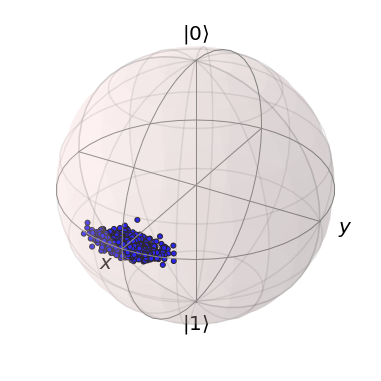

In [17]:
b = qt.Bloch()
b.add_points(tp.blah)
b.show()

In [62]:
tp.sample(2)

/home/ihincks/.miniconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


(array([  2.,   1.,   9.,  22.,  54.,  94., 200., 343., 451., 324.]),
 array([0.48316608, 0.53473413, 0.58630218, 0.63787023, 0.68943828,
        0.74100633, 0.79257438, 0.84414243, 0.89571048, 0.94727853,
        0.99884658]),
 <a list of 10 Patch objects>)

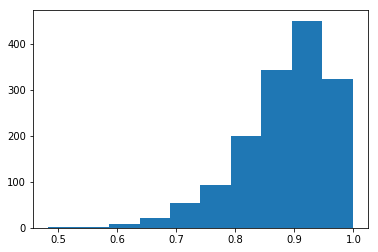

In [56]:
plt.hist(np.real(np.dot(tp.states.reshape(-1,4), qt.sigmaz().data.toarray().flatten())))

In [75]:
np.sum(np.linalg.eig(rho[5,...])[0])

(0.9999999999999998+7.51112678311022e-33j)

In [5]:
np.sum(f['L_real'][5,:]**2 + f['L_imag'][5,:]**2)

1.0000000000000002

In [67]:
A = f[('rho_real')][5,...]
B = f[('rho_imag')][5,...]
Asq = mpow(A, -1/2)

In [69]:
np.trace(A)

1.0000000000000002

In [63]:
np.linalg.slogdet(A+1j*B)[1]

-88.34932346130041

In [66]:
np.linalg.slogdet(A)[1] + np.sum(np.log(
    np.sqrt(1 - np.linalg.svd(np.dot(Asq, np.dot(B, Asq)))[1]**2)
))

-88.3493234604548

In [64]:
np.linalg.svd(np.dot(Asq, np.dot(B, Asq)))[1]

array([0.99998899, 0.99998899, 0.99674496, 0.99674496, 0.95974601,
       0.95974601, 0.83532131, 0.83532131, 0.73120647, 0.73120647,
       0.6208288 , 0.6208288 , 0.38464414, 0.38464414, 0.08830717,
       0.08830717])

In [60]:
np.linalg.eig(Asq)[0]

array([41.38603026, 26.33953694, 20.05655553, 14.21577328, 13.37728693,
        1.23785545, 10.83863184,  9.17930767,  3.28504186,  3.99960816,
        4.74876357,  5.81399932,  7.58213017,  6.45807816,  7.19901886,
        6.71464777])

In [18]:
np.linalg.norm(A)

0.6657837546979709

In [11]:
np.linalg.norm(A - np.dot(Asq, Asq.T))

6.799806246723813e-17

In [25]:
A = np.random.randn(25) + 1j * np.random.randn(25)
A = A.reshape(5,5)
B = np.dot(A, A.conj().T)

In [31]:
np.linalg.eig(np.imag(B))

(array([ 4.44089210e-16+14.08232144j,  4.44089210e-16-14.08232144j,
        -1.11022302e-16 +3.45967237j, -1.11022302e-16 -3.45967237j,
        -2.86942026e-17 +0.j        ]),
 array([[ 0.02396943+0.37482565j,  0.02396943-0.37482565j,
         -0.04366363-0.59696879j, -0.04366363+0.59696879j,
         -0.03613709+0.j        ],
        [ 0.67591234+0.j        ,  0.67591234-0.j        ,
         -0.17708895+0.03570421j, -0.17708895-0.03570421j,
          0.14496359+0.j        ],
        [-0.09479249+0.53712987j, -0.09479249-0.53712987j,
         -0.1383021 +0.33198547j, -0.1383021 -0.33198547j,
          0.3825286 +0.j        ],
        [ 0.12074161+0.25346643j,  0.12074161-0.25346643j,
          0.14598496+0.17927385j,  0.14598496-0.17927385j,
         -0.85758441+0.j        ],
        [ 0.13785435+0.08217058j,  0.13785435-0.08217058j,
          0.65291187+0.j        ,  0.65291187-0.j        ,
          0.3096781 +0.j        ]]))

In [33]:
np.real(np.linalg.eigvals(B))

array([31.49339983, 26.95247654,  0.1758025 ,  5.85239547,  3.02632204])

In [34]:
np.real(np.linalg.eigvals(np.real(B)))

array([26.90007167, 20.36858942, 13.20333039,  2.16742724,  4.86097766])